In [1]:
__author__ = 'Boquan Chen'
%matplotlib inline

from astropy.io import fits
from astropy.table import unique, Table, join, Column
from astropy.coordinates import Galactic, SkyCoord, ICRS, Distance
import astropy.coordinates as coord
from astropy import units as u
from astropy.time import Time
from collections import Counter
import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib as mpl
from matplotlib import rc
from matplotlib.colors import ListedColormap
import multiprocessing as mp
import numpy as np
import os
import pandas as pd
import pickle
from scipy.stats.distributions import uniform, randint
from scipy.sparse import lil_matrix
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn import manifold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.model_selection import ParameterSampler
import time
from tqdm import tqdm, tnrange, tqdm_notebook
# change default font in plots
del mpl.font_manager.weight_dict['roman']
mpl.font_manager._rebuild()
plt.rcParams.update({'font.size': 12})
plt.rcParams['image.cmap'] = 'gist_rainbow'
plt.rcParams["font.family"] = 'Times New Roman'
# date today
date_today = datetime.date.today().strftime('%Y%m%d')

In [2]:
def jaccard(a,b):
    """
    Computes the Jaccard distance between two arrays.
    
    Parameters
    ----------
    a: an array.
    
    b: an array.
    
    """
    A = np.array(a, dtype='int')
    B = np.array(b, dtype='int')
    A = A[np.where(A > -1)[0]]
    B = B[np.where(B > -1)[0]]
    union = np.union1d(A,B)
    intersection = np.intersect1d(A,B)
    return 1.0 - len(intersection)*1.0 / len(union)

In [3]:
def iterator_dist(indices, k_min=5):
    """
    An iterator that computes the Jaccard distance for any pair of stars. 
    
    Parameters: 
    
    indices: the indices of nearest neighbors in the chemistry-velocity space. 
    
    """
    
    for n in range(len(indices)):
        for m in indices[n][indices[n] > n]:
            if len(np.intersect1d(indices[n], indices[m])) > k_min:
                dist = jaccard(indices[n], indices[m])
                yield (n, m, dist)

In [4]:
filename = "Orion_data_20190924.csv"
df = pd.read_csv(filename)
df.dropna(subset=['ra', 'dec', 'parallax', 'pmra', 'pmdec'])
df = df.reset_index(drop=True)
print(f'{len(df)} stars in total in the Orion region.')

29030 stars in total in the Orion region.


In [5]:
df.columns.values

array(['ra', 'ra_error', 'dec', 'dec_error', 'source_id', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'dec_parallax_corr', 'dec_pmdec_corr', 'dec_pmra_corr',
       'parallax_pmdec_corr', 'parallax_pmra_corr', 'pmra_pmdec_corr',
       'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'duplicated_source', 'phot_g_mean_flux', 'phot_g_mean_flux_error',
       'phot_g_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
       'phot_bp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error',
       'phot_rp_mean_mag', 'bp_rp', 'radial_velocity',
       'radial_velocity_error', 'teff_val', 'a_g_val', 'e_bp_min_rp_val',
       'radius_val', 'lum_val', 'ruwe'], dtype=object)

## Construct Covariance Matrix

In [6]:
def build_cov(error):
    """
    Construct within-source covariance matrix from Gaia DR2. 
    
    Parameters
    ----------
    
    error: pandas Dataframe
        contains errors and correlations for 5D astrometric data from Gaia DR2
        
    Returns
    -------
    
    cov: 5 by 5 numpy matrix
        covariance matrix for 5D astrometric data from Gaia DR2
    """
    cov = np.zeros((5, 5))
    cov[0][0] = np.square(error['ra_error'])
    cov[0][1] = error['ra_error'] * error['dec_error'] * error['ra_dec_corr']
    cov[0][2] = error['ra_error'] * error['pmra_error'] * error['ra_pmra_corr']
    cov[0][3] = error['ra_error'] * error['pmdec_error'] * error['ra_pmdec_corr']
    cov[0][4] = error['ra_error'] * error['parallax_error'] * error['ra_parallax_corr']
    cov[1][0] = cov[0][1]
    cov[1][1] = np.square(error['dec_error'])
    cov[1][2] = error['dec_error'] * error['pmra_error'] * error['dec_pmra_corr']
    cov[1][3] = error['dec_error'] * error['pmdec_error'] * error['dec_pmdec_corr']
    cov[1][4] = error['dec_error'] * error['parallax_error'] * error['dec_parallax_corr']
    cov[2][0] = cov[0][2]
    cov[2][1] = cov[1][2]
    cov[2][2] = np.square(error['pmra_error'])
    cov[2][3] = error['pmra_error'] * error['pmdec_error'] * error['pmra_pmdec_corr']
    cov[2][4] = error['pmra_error'] * error['parallax_error'] * error['parallax_pmra_corr']
    cov[3][0] = cov[0][3]
    cov[3][1] = cov[1][3]
    cov[3][2] = cov[2][3]
    cov[3][3] = np.square(error['pmdec_error'])
    cov[3][4] = error['pmdec_error'] * error['parallax_error'] * error['parallax_pmdec_corr']
    cov[4][0] = cov[0][4]
    cov[4][1] = cov[1][4]
    cov[4][2] = cov[2][4]
    cov[4][3] = cov[3][4]
    cov[4][4] = np.square(error['parallax_error'])
    return cov

In [7]:
mean_colnames = ['ra', 'dec', 'pmra', 'pmdec', 'parallax']
error_colnames = ['ra_error', 'ra_dec_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'ra_parallax_corr', 
                  'dec_error', 'dec_pmra_corr', 'dec_pmdec_corr', 'dec_parallax_corr', 
                  'pmra_error', 'pmra_pmdec_corr', 'parallax_pmra_corr', 
                  'pmdec_error', 'parallax_pmdec_corr', 
                  'parallax_error']
means = df[mean_colnames]
errors = df[error_colnames]

## Stage I of SNN: Generate Initial Groups

In [8]:
def run_snn(n_xyz, d_pm):
    """
    Function for one run of SNN for parallel processes. 
    
    Parameters
    ----------
    n_xyz: int 
        number of nearest neighbors in converted 3D cartesian coordinates 
        
    d_pm: float
        maximum difference between proper motion vectors of a star and its nearest neighbors in (x,y,z)
        
    Returns
    -------
    
    labels: 1D numpy array
        membership labels for SNN groups
    
    n_xyz: int 
        number of nearest neighbors in converted 3D cartesian coordinates 
        
    d_pm: float
        maximum difference between proper motion vectors of a star and its nearest neighbors in (x,y,z)
    
    """
    eps = 0.5 # DBSCAN parameter
    min_samples = 20 # DBSCAN parameter
    data = np.array([np.random.multivariate_normal(means.iloc[i], cov=build_cov(errors.iloc[i])) 
                         for i in range(means.shape[0])])
    # convert (ra, dec, parallax) to Cartesian (x, y, z)
    c = SkyCoord(ra=data[:,0]*u.degree, dec=data[:,1]*u.degree, 
                 distance=Distance(parallax=data[:,-1]*u.mas), 
                 obstime=Time(2015.5, format='decimalyear'))
    xyz = c.cartesian.xyz.value.T
    # retrieve nearest neighbors in Cartesian coordinates
    nbrs = NearestNeighbors(n_neighbors=n_xyz).fit(xyz)
    distances, indices = nbrs.kneighbors(xyz)
    # prune the neighbors of each star by removing stars with dissimilar proper motions
    indices = np.array([i[euclidean_distances(data[:,2:4][i], [data[:,2:4][i[0]]]).flatten() < d_pm] for i in indices])
    # # compile distance matrix with nearest neighbor array
    S = lil_matrix((len(distances), len(distances)))
    for (n, m, dist) in iterator_dist(indices, k_min=5):
        S[n,m] = dist
        S[m,n] = dist
    # DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed', n_jobs=-1).fit(S)
    labels = db.labels_
    n_cls = np.amax(labels) + 1
    return labels, n_xyz, d_pm

In [9]:
# number of runs
n_runs = 7000
# construct grid of random parameter values within ranges
param_grid = {'n_xyz': randint(10, 1000), 'd_pm': uniform(0, 0.6)}
params = np.array(list(ParameterSampler(param_grid, n_iter=n_runs)))

In [10]:
%%time

# set up parallel processes
pool = mp.Pool(mp.cpu_count())
result_objects = [pool.apply_async(run_snn, args=(param['n_xyz'], param['d_pm'])) for param in params]

# saving results and parameter values from individual runs
results = np.array([r.get()[0] for r in result_objects])
used_params = np.array([[r.get()[1], r.get()[2]] for r in result_objects])

CPU times: user 44.9 s, sys: 18.4 s, total: 1min 3s
Wall time: 21h 25min 41s


Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Traceback (most recent call last):
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File

In [11]:
# save results from individual runs
pickle.dump(results, open(f"results_{date_today}_rawpm.p", "wb"))
pickle.dump(used_params, open(f"params_{date_today}_rawpm.p", "wb"))

# comment out the above and uncomment the following if the individual runs have been completed prior
# results = pickle.load(open("results_20190926_rawpm.p", "rb"))
# params = pickle.load(open("params_20190926_rawpm.p", "rb"))

In [12]:
%%time

# retrieve all groups from individual runs
groups = []
sizes = []
for i in range(results.shape[0]):
    for j in range(max(results[i])+1):
        groups.append(np.where(results[i] == j)[0])  
        sizes.append(np.sum(results[i] == j))
sizes = np.array(sizes)
groups = np.array(groups)
# remove groups with under 30 stars
groups = groups[sizes > 30]
print(f'{len(groups)} groups found in the initial step')

26885 groups found in the initial step
CPU times: user 19.6 s, sys: 0 ns, total: 19.6 s
Wall time: 19.6 s


## Stage II of SNN: Clustering of Initial Groups

In [13]:
def index_distance(rows):
    """
    Compute the inter-cluster distance for specified rows. Used for parallel processes. 
    """
    ind_dist = []
    for n in rows:
        for m in range(n+1, len(groups)):
            if len(np.intersect1d(groups[n], groups[m])) > 20:
                dist = jaccard(groups[n], groups[m])
                ind_dist.append([n, m, dist])
    return ind_dist

In [14]:
# Split initial groups into chunks for parallel processes 
array_rows = np.arange(len(groups))
num_chunks = mp.cpu_count()
array_rows = np.array([array_rows[i::num_chunks] for i in range(num_chunks)])

In [15]:
%%time

# set up parallel processes for computing a distance matrix for stage II SNN
pool = mp.Pool(mp.cpu_count())
result_objects = [pool.apply_async(index_distance, args=[rows]) for rows in array_rows]

# compute distance matrix
S = lil_matrix((len(groups), len(groups)))
for r in result_objects:
    for i in range(len(r.get())):
        S[int(r.get()[i][0]), int(r.get()[i][1])] = r.get()[i][2]

CPU times: user 3min 1s, sys: 2.76 s, total: 3min 4s
Wall time: 47min 19s


Process ForkPoolWorker-14:
Process ForkPoolWorker-11:
Process ForkPoolWorker-13:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Process ForkPoolWorker-10:
Traceback (most recent call last):
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/boquan/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File

In [16]:
%%time

# Stage II SNN
min_samples = 15
eps = 0.70
db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(S)
cls_labels = db.labels_
print(Counter(cls_labels))
print(f'{max(cls_labels)+1} clusters recovered')

Counter({6: 3566, 4: 3337, 0: 3284, -1: 3201, 1: 2839, 2: 2304, 3: 1970, 7: 1463, 5: 1044, 15: 978, 25: 790, 14: 626, 27: 493, 19: 160, 41: 127, 55: 122, 16: 112, 51: 105, 30: 46, 67: 46, 71: 31, 54: 26, 83: 19, 11: 18, 64: 18, 12: 13, 13: 12, 87: 9, 38: 8, 8: 6, 36: 6, 61: 6, 20: 5, 56: 5, 24: 4, 34: 4, 86: 4, 92: 4, 23: 3, 42: 3, 52: 3, 9: 2, 10: 2, 32: 2, 43: 2, 44: 2, 48: 2, 50: 2, 58: 2, 62: 2, 65: 2, 91: 2, 17: 1, 18: 1, 21: 1, 22: 1, 26: 1, 28: 1, 29: 1, 31: 1, 33: 1, 35: 1, 37: 1, 39: 1, 40: 1, 45: 1, 46: 1, 47: 1, 49: 1, 53: 1, 57: 1, 59: 1, 60: 1, 63: 1, 66: 1, 68: 1, 69: 1, 70: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 84: 1, 85: 1, 88: 1, 89: 1, 90: 1, 93: 1})
94 clusters recovered
CPU times: user 8.33 s, sys: 1.07 s, total: 9.41 s
Wall time: 8.16 s


In [17]:
pickle.dump(cls_labels, open(f"cls_labels_{date_today}.p", "wb"))
# comment out the line above and uncomment the line below if Stage II SNN has been run
# cls_labels = pickle.load(open('cls_labels_date.p', 'rb'))

In [18]:
%%time

# generate unique groups from Stage II SNN
cls_members = []
cls_density = []
cls_sizes = []
cls_stability = []
for n in range(max(cls_labels)+1):
    cls_indices = np.where(cls_labels == n)[0]
    if len(cls_indices) >= 1:
        flat_list = [item for clump in groups[cls_indices] for item in clump]
        members = np.array(list(set(flat_list)))
        density = np.array([np.sum(flat_list == member)/len(cls_indices) for member in members])
        cls_members.append(members)
        cls_density.append(density)
        cls_sizes.append(len(members))
        cls_stability.append(len(cls_indices))
cls_stability = np.array(cls_stability)
order = np.argsort(-cls_stability)
cls_members = np.array(cls_members)[order]
cls_density = np.array(cls_density)[order]
cls_sizes = np.array(cls_sizes)[order]
cls_stability = cls_stability[order]

CPU times: user 6min 16s, sys: 0 ns, total: 6min 16s
Wall time: 6min 16s


In [22]:
df_result = pd.DataFrame()
for i in range(27):
    members = cls_members[i]
    prob = cls_density[i]
    stability = cls_stability[i]
    df_temp = df.loc[members]
    df_temp['probability'] = prob
    df_temp['stability'] = stability
    df_temp['label'] = i+1
    df_result = df_result.append(df_temp)
df_result = df_result.reset_index(drop=True)
df_result.loc[df_result['probability'] > 0.1].to_csv(f'final_result_{date_today}.csv')

## Plot Results in 5D Astrometric Space

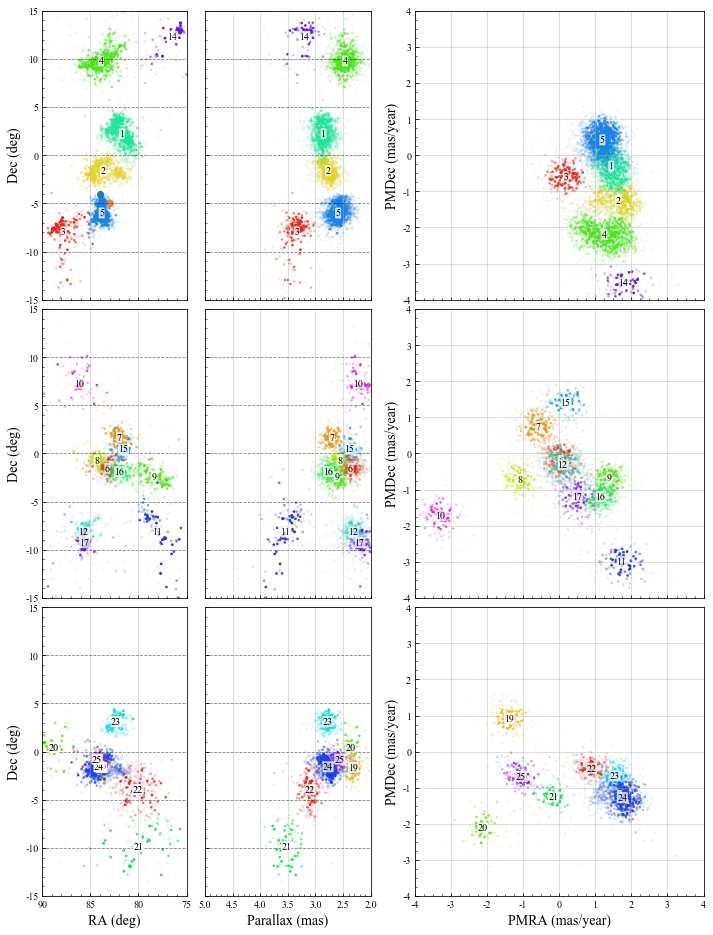

In [35]:
ind_0 = np.array([2, 1, 3, 0, 4, 13]) + 1
ind_1 = np.array([5, 6, 7, 8, 15, 11, 14, 10, 16, 9]) + 1
ind_2 = np.array([21, 18, 19, 20, 22, 23, 24]) + 1

fig = plt.figure(figsize=(10.5, 15))

gs = gridspec.GridSpec(3, 3, width_ratios=[1.2, 1.1, 2.5]) 

bbox_props = dict(boxstyle="round, pad=0", fc="w", alpha=0.7, ec="2")
arrowprops = {'arrowstyle': '-'}
cmap = ListedColormap(sns.hls_palette(len(ind_0)+1, l=.5, s=.8))
colors = cmap(np.linspace(0, 1, len(ind_0)+1))

ax1 = plt.subplot(gs[0])
ax1.tick_params(which='both', direction='in')
x = df_result.ra.values
y = df_result.dec.values
for n in range(len(ind_0)):
    members = np.where(df_result['label'] == ind_0[n])[0]
    alpha = df_result['probability'][members].values
    c = np.array([colors[n] for _ in range(len(members))])
    c[:,3] = alpha
    ax1.scatter(x[members], y[members], c=c, s=3)
    ax1.text(np.sum(x[members]*alpha)/np.sum(alpha), 
             np.sum(y[members]*alpha)/np.sum(alpha), f'{ind_0[n]}', 
             ha="center", va="center", size=10, bbox=bbox_props)
    
ax1.scatter([84], [-4])
ax1.scatter([83], [-5])
ax1.set_xlim(75., 90.)
ax1.set_ylim(-15, 15)
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax1.set_aspect('equal', adjustable='box')
ax1.invert_xaxis()
ax1.set_xticklabels([])
ax1.set_ylabel("Dec (deg)", fontsize=14)
ax1.grid(True, markevery=5, alpha=0.5, axis='x')
ax1.grid(True, markevery=5, alpha=0.5, c='black', linestyle='--', axis='y')

ax2 = plt.subplot(gs[1])
ax2.tick_params(which='both', direction='in')
x = df_result.parallax.values
y = df_result.dec.values
for n in range(len(ind_0)):
    members = np.where(df_result['label'] == ind_0[n])[0]
    alpha = df_result['probability'][members].values
    c = np.array([colors[n] for _ in range(len(members))])
    c[:,3] = alpha
    ax2.scatter(x[members], y[members], c=c, s=3)
    ax2.text(np.sum(x[members]*alpha)/np.sum(alpha), 
             np.sum(y[members]*alpha)/np.sum(alpha), f'{ind_0[n]}', 
             ha="center", va="center", size=10, bbox=bbox_props)
    
ax2.set_xlim(2, 5)
ax2.set_ylim(-15, 15)
ax2.xaxis.set_minor_locator(MultipleLocator(0.1))
ax2.xaxis.set_major_locator(MultipleLocator(0.5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax2.invert_xaxis()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(True, markevery=5, alpha=0.5, axis='x')
ax2.grid(True, markevery=5, alpha=0.5, c='black', linestyle='--', axis='y')

ax3 = plt.subplot(gs[2])
ax3.tick_params(which='both', direction='in')
x = df_result.pmra.values
y = df_result.pmdec.values
for n in range(len(ind_0)):
    members = np.where(df_result['label'] == ind_0[n])[0]
    alpha = df_result['probability'][members].values
    c = np.array([colors[n] for _ in range(len(members))])
    c[:,3] = alpha
    ax3.scatter(x[members], y[members], c=c, s=3)
    ax3.text(np.sum(x[members]*alpha)/np.sum(alpha), 
             np.sum(y[members]*alpha)/np.sum(alpha), f'{ind_0[n]}', 
             ha="center", va="center", size=10, bbox=bbox_props)
ax3.set_xlim(-4, 4)
ax3.set_ylim(-4, 4)
ax3.set_aspect('equal')
ax3.xaxis.set_minor_locator(MultipleLocator(0.25))
ax3.xaxis.set_major_locator(MultipleLocator(1))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax3.yaxis.set_minor_locator(MultipleLocator(0.25))
ax3.yaxis.set_major_locator(MultipleLocator(1))
ax3.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax3.set_ylabel("PMDec (mas/year)", fontsize=14)
ax3.grid(True, markevery=5, alpha=0.5)
ax3.set_xticklabels([])

#/////////////////////////////////////////////////////////////////////////////////////
cmap = ListedColormap(sns.hls_palette(len(ind_1)+1, l=.5, s=.8))
colors = cmap(np.linspace(0, 1, len(ind_1)+1))

ax4 = plt.subplot(gs[3])
ax4.tick_params(which='both', direction='in')
x = df_result.ra.values
y = df_result.dec.values
for n in range(len(ind_1)):
    members = np.where(df_result['label'] == ind_1[n])[0]
    alpha = df_result['probability'][members].values
    c = np.array([colors[n] for _ in range(len(members))])
    c[:,3] = alpha
    ax4.scatter(x[members], y[members], c=c, s=3)
    ax4.text(np.sum(x[members]*alpha)/np.sum(alpha), 
             np.sum(y[members]*alpha)/np.sum(alpha), f'{ind_1[n]}', 
             ha="center", va="center", size=10, bbox=bbox_props)
ax4.set_xlim(75., 90.)
ax4.set_ylim(-15, 15)
ax4.xaxis.set_minor_locator(MultipleLocator(1))
ax4.xaxis.set_major_locator(MultipleLocator(5))
ax4.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax4.yaxis.set_minor_locator(MultipleLocator(1))
ax4.yaxis.set_major_locator(MultipleLocator(5))
ax4.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax4.set_aspect('equal', adjustable='box')
ax4.invert_xaxis()
ax4.set_xticklabels([])
ax4.set_ylabel("Dec (deg)", fontsize=14)
ax4.grid(True, markevery=5, alpha=0.5, axis='x')
ax4.grid(True, markevery=5, alpha=0.5, c='black', linestyle='--', axis='y')

ax5 = plt.subplot(gs[4])
ax5.tick_params(which='both', direction='in')
x = df_result.parallax.values
y = df_result.dec.values
for n in range(len(ind_1)):
    members = np.where(df_result['label'] == ind_1[n])[0]
    alpha = df_result['probability'][members].values
    c = np.array([colors[n] for _ in range(len(members))])
    c[:,3] = alpha
    ax5.scatter(x[members], y[members], c=c, s=3)
    ax5.text(np.sum(x[members]*alpha)/np.sum(alpha), 
             np.sum(y[members]*alpha)/np.sum(alpha), f'{ind_1[n]}', 
             ha="center", va="center", size=10, bbox=bbox_props)
ax5.set_xlim(2, 5)
ax5.set_ylim(-15, 15)
ax5.xaxis.set_minor_locator(MultipleLocator(0.1))
ax5.xaxis.set_major_locator(MultipleLocator(0.5))
ax5.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax5.yaxis.set_minor_locator(MultipleLocator(1))
ax5.yaxis.set_major_locator(MultipleLocator(5))
ax5.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax5.invert_xaxis()
ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax5.grid(True, markevery=5, alpha=0.5, axis='x')
ax5.grid(True, markevery=5, alpha=0.5, c='black', linestyle='--', axis='y')

ax6 = plt.subplot(gs[5])
ax6.tick_params(which='both', direction='in')
x = df_result.pmra.values
y = df_result.pmdec.values
for n in range(len(ind_1)):
    members = np.where(df_result['label'] == ind_1[n])[0]
    alpha = df_result['probability'][members].values
    c = np.array([colors[n] for _ in range(len(members))])
    c[:,3] = alpha
    ax6.scatter(x[members], y[members], c=c, s=3)
    if ind_1[n] == 5:
        ax6.annotate(f'{text1[n]}', xy=[np.sum(x[members]*alpha)/np.sum(alpha), 
                                        np.sum(y[members]*alpha)/np.sum(alpha)], 
                     xytext=[0.8, -0.2], xycoords='data', size=10, bbox=bbox_props, arrowprops=arrowprops)
    else:
        ax6.text(np.sum(x[members]*alpha)/np.sum(alpha), 
                 np.sum(y[members]*alpha)/np.sum(alpha), f'{ind_1[n]}', 
                 ha="center", va="center", size=10, bbox=bbox_props)
ax6.set_xlim(-4, 4)
ax6.set_ylim(-4, 4)
ax6.set_aspect('equal')
ax6.xaxis.set_minor_locator(MultipleLocator(0.25))
ax6.xaxis.set_major_locator(MultipleLocator(1))
ax6.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax6.yaxis.set_minor_locator(MultipleLocator(0.25))
ax6.yaxis.set_major_locator(MultipleLocator(1))
ax6.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax6.set_xticklabels([])
ax6.set_ylabel("PMDec (mas/year)", fontsize=14)
ax6.grid(True, markevery=5, alpha=0.5)
    
#/////////////////////////////////////////////////////////////////////////////

cmap = ListedColormap(sns.hls_palette(len(ind_2)+1, l=.5, s=.8))
colors = cmap(np.linspace(0, 1, len(ind_2)+1))


ax7 = plt.subplot(gs[6])
ax7.tick_params(which='both', direction='in')
x = df_result.ra.values
y = df_result.dec.values
for n in range(len(ind_2)):
    members = np.where(df_result['label'] == ind_2[n])[0]
    alpha = df_result['probability'][members].values
    c = np.array([colors[n] for _ in range(len(members))])
    c[:,3] = alpha
    ax7.scatter(x[members], y[members], c=c, s=3)
    ax7.text(np.sum(x[members]*alpha)/np.sum(alpha), 
             np.sum(y[members]*alpha)/np.sum(alpha), f'{ind_2[n]}', 
             ha="center", va="center", size=10, bbox=bbox_props)
    if ind_2[n] == 17:
        ax7.annotate(f'{text2[n]}', xy=[np.sum(x[members]*alpha)/np.sum(alpha), 
                                        np.sum(y[members]*alpha)/np.sum(alpha)], 
                     xytext=[86, 1], xycoords='data', size=10, bbox=bbox_props, arrowprops=arrowprops)
    else:
        ax7.text(np.sum(x[members]*alpha)/np.sum(alpha), 
                 np.sum(y[members]*alpha)/np.sum(alpha), f'{ind_2[n]}', 
                 ha="center", va="center", size=10, bbox=bbox_props)
ax7.set_xlim(75., 90.)
ax7.set_ylim(-15, 15)
ax7.xaxis.set_minor_locator(MultipleLocator(1))
ax7.xaxis.set_major_locator(MultipleLocator(5))
ax7.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax7.yaxis.set_minor_locator(MultipleLocator(1))
ax7.yaxis.set_major_locator(MultipleLocator(5))
ax7.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax7.set_aspect('equal', adjustable='box')
ax7.invert_xaxis()
ax7.set_xlabel("RA (deg)", fontsize=14)
ax7.set_ylabel("Dec (deg)", fontsize=14)
ax7.grid(True, markevery=5, alpha=0.5, axis='x')
ax7.grid(True, markevery=5, alpha=0.5, c='black', linestyle='--', axis='y')

ax8 = plt.subplot(gs[7])
ax8.tick_params(which='both', direction='in')
x = df_result.parallax.values
y = df_result.dec.values
for n in range(len(ind_2)):
    members = np.where(df_result['label'] == ind_2[n])[0]
    alpha = df_result['probability'][members].values
    c = np.array([colors[n] for _ in range(len(members))])
    c[:,3] = alpha
    ax8.scatter(x[members], y[members], c=c, s=3)
    ax8.text(np.sum(x[members]*alpha)/np.sum(alpha), 
             np.sum(y[members]*alpha)/np.sum(alpha), f'{ind_2[n]}', 
             ha="center", va="center", size=10, bbox=bbox_props)

ax8.set_xlim(2, 5)
ax8.set_ylim(-15, 15)
ax8.xaxis.set_minor_locator(MultipleLocator(0.1))
ax8.xaxis.set_major_locator(MultipleLocator(0.5))
ax8.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax8.yaxis.set_minor_locator(MultipleLocator(1))
ax8.yaxis.set_major_locator(MultipleLocator(5))
ax8.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax8.invert_xaxis()
ax8.set_xlabel("Parallax (mas)", fontsize=14)
ax8.set_yticklabels([])
ax8.grid(True, markevery=5, alpha=0.5, axis='x')
ax8.grid(True, markevery=5, alpha=0.5, c='black', linestyle='--', axis='y')

ax9 = plt.subplot(gs[8])
ax9.tick_params(which='both', direction='in')
x = df_result.pmra.values
y = df_result.pmdec.values
for n in range(len(ind_2)):
    members = np.where(df_result['label'] == ind_2[n])[0]
    alpha = df_result['probability'][members].values
    c = np.array([colors[n] for _ in range(len(members))])
    c[:,3] = alpha
    ax9.scatter(x[members], y[members], c=c, s=3)
    ax9.text(np.sum(x[members]*alpha)/np.sum(alpha), 
             np.sum(y[members]*alpha)/np.sum(alpha), f'{ind_2[n]}', 
             ha="center", va="center", size=10, bbox=bbox_props)
ax9.set_xlim(-4, 4)
ax9.set_ylim(-4, 4)
ax9.set_aspect('equal')
ax9.xaxis.set_minor_locator(MultipleLocator(0.25))
ax9.xaxis.set_major_locator(MultipleLocator(1))
ax9.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax9.yaxis.set_minor_locator(MultipleLocator(0.25))
ax9.yaxis.set_major_locator(MultipleLocator(1))
ax9.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax9.set_xlabel("PMRA (mas/year)", fontsize=14)
ax9.set_ylabel("PMDec (mas/year)", fontsize=14)
ax9.grid(True, markevery=5, alpha=0.5)


plt.tight_layout(pad=0.1)
plt.subplots_adjust(top=0.85, wspace=0)
# plt.savefig(f'Orion_radec_snn_{date_today}.pdf_result', bbox_inches='tight',pad_inches=0)
# plt.savefig(f'Orion_radec_snn_{date_today}.png', dpi=150, bbox_inches='tight',pad_inches=0)
plt.show()